In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.constants import golden
plt.style.use('default')

# VARIABILI
csvfile = '/home/jovyan/tesi/csv/alldata.csv'
distance_param = 'CDistance'
colori = ['slategray', 'firebrick', 'darkorange', 'limegreen', 'slateblue']

myindex = [
    '7:00', '8:00', '9:00', '10:00',
    '11:00', '12:00', '13:00', '14:00',
    '15:00','16:00', '17:00', '18:00',
    '19:00', '20:00', '21:00', '22:00',
    '23:00']

plterrindex = [
    '10:00', '11:00', '12:00', '13:00',
    '14:00', '15:00','16:00', '17:00',
    '18:00', '19:00', '20:00', '21:00',
    '22:00', '23:00', '7:00', '8:00',
    '9:00']


# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[post_lock_cond]

def clean(df):
    distance_cond = df[distance_param] > 0
    moovit_cond = df['Public'] > 12
    public_cond = df['Public'] > 0
    bike_cond = df['Bike'] > 0
    foot_cond = df['Foot'] > 0
    car_cond = df['Car'] > 0
    car2go_cond = df['Car2Go'] > 0
    enjoy_cond = df['Enjoy'] > 0
    coherence_cond = (df['Car'] <= df['Car2Go']) & (df['Car'] <= df['Enjoy'])
    cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond
    return cleaned

In [2]:
replace = {}
replace['Car'] = 'Auto'
replace['Public'] = 'ATM'
replace['Bike'] = 'Bici'
replace['Foot'] = 'A piedi'
replace['Enjoy'] = 'Enjoy'

# Velocita' media durante il giorno
def vmedia_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore

def vstd_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(2 * np.std(velocita_media_oraria, ddof=1))
    return vmedia_giorno_ore

def vmedia_week(df, mezzo):    
    lst = vmedia_week_list(df, mezzo)
    array = np.array(lst).T
    return pd.DataFrame(array, index=myindex, columns=[replace[mezzo]]).round(1)

def vmedia_week_list(df, mezzo):    
    return [vmedia_giorno(df, mezzo)]

def week_filters(df):
    sd = 4
    weeks = \
        ((df['Month'] == 5) & (
            (df['Day'].between(sd, sd + 4)) |
            (df['Day'].between(sd + 7, sd + 7 + 4)) |
            (df['Day'].between(sd + 7*2, sd + 7*2 + 4)) |
            (df['Day'].between(sd + 7*3, sd + 7*3 + 4)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1, 1 + 4)) |
            (df['Day'].between(1 + 7, 1 + 7 + 4)) |
            (df['Day'].between(1 + 7*2, 1 + 7*2 + 4)) |
            (df['Day'].between(1 + 7*3, 1+7*3 + 4))))

    weekends = \
        ((df['Month'] == 5) & (
            (df['Day'].between(sd + 5, sd + 5 + 1)) |
            (df['Day'].between(sd + 7 + 5, sd + 7 + 5 + 1)) |
            (df['Day'].between(sd + 7*2 + 5, sd + 7*2 + 5 + 1)) |
            (df['Day'].between(sd + 7*3 + 5, sd + 7*3 + 5 + 1)))) | \
        ((df['Month'] == 6) & (
            (df['Day'].between(1 + 5, 1 + 5 + 1)) |
            (df['Day'].between(1 + 7 + 5, 1 + 7 + 5 + 1)) |
            (df['Day'].between(1 + 7*2 + 5, 1 + 7*2 + 5 + 1)) |
            (df['Day'].between(1 + 7*3 + 5, 1 + 7*3 + 5 + 1))))
    
    return weeks, weekends

tragitti = tragitti[clean(tragitti)]
w, we = week_filters(tragitti)

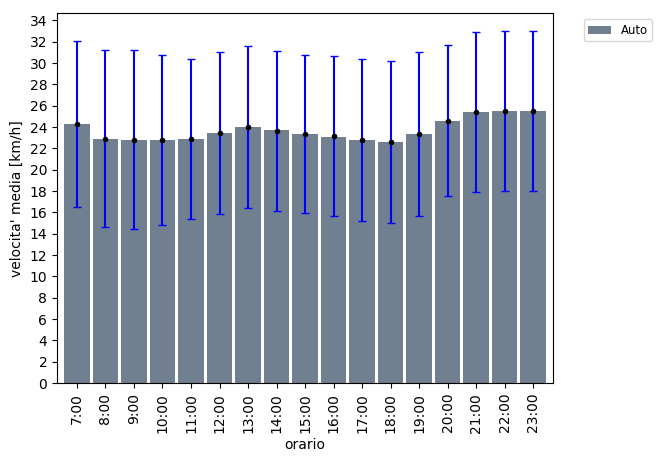

In [3]:
vmedia_week(tragitti, 'Car').plot.bar(width=0.9, align='center', color=colori[0])
plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

x = plterrindex
y = vmedia_week_list(tragitti, 'Car')[0]
dy = np.round(vstd_giorno(tragitti, 'Car'), 1).tolist()
plt.errorbar(x, y, yerr=dy, lw=1.5, fmt='.k', color='black', ecolor='blue', capsize=3)

plt.yticks(range(0, 35, 2))
plt.show()

In [4]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Car']
velocita_media.describe()

count    49560.000000
mean        23.838455
std          3.970546
min          8.912400
25%         21.171049
50%         23.715333
75%         26.321036
max         59.076545
dtype: float64

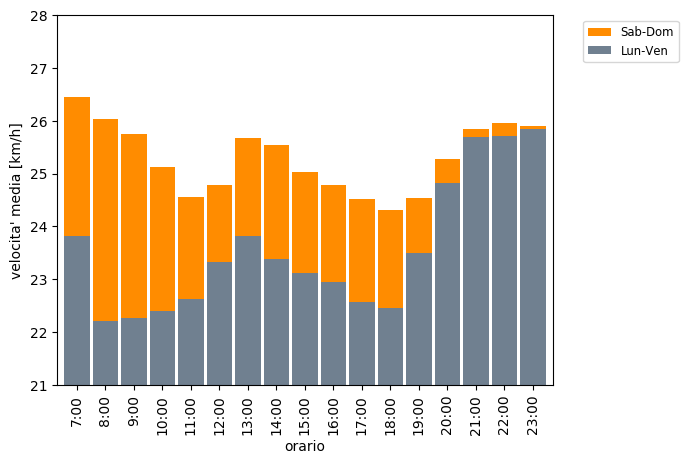

In [5]:
distance_param = 'CDistance'
lst = [
    vmedia_week_list(tragitti[w], 'Car')[0],
    vmedia_week_list(tragitti[we], 'Car')[0]]

def list_minus(l1, l2):
    r = []
    for i in range(0, len(l1)):
        r.append(l1[i] - l2[i])
    return r

a = list_minus(lst[1], lst[0])
b = lst[0]

lst = [b, a]

array = np.array(lst).T

x = pd.DataFrame(array, index=myindex, columns=['Week', 'Weekend'])

x.plot.bar(stacked=True, width=0.9, align='center', color=['slategray', 'darkorange'])

plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(reversed(plt.legend().legendHandles), reversed(['Lun-Ven', 'Sab-Dom']), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.yticks(range(0, 31, 1))
plt.ylim((21, 28))

plt.show()

In [6]:
x, y = vmedia_week_list(tragitti[we], 'Car')[0], vmedia_week_list(tragitti[w], 'Car')[0]
for i in range(0, len(x)):
    z = x[i] - y[i]
    print (z / x[i]) * 100


9.96052450594
14.6824608657
13.5611859034
10.8277110016
7.82787909657
5.84427484012
7.2200970641
8.4775073304
7.69220851112
7.41475794652
7.99919914464
7.64721456671
4.23620374457
1.83676091541
0.609722164222
0.915586172999
0.246464453948


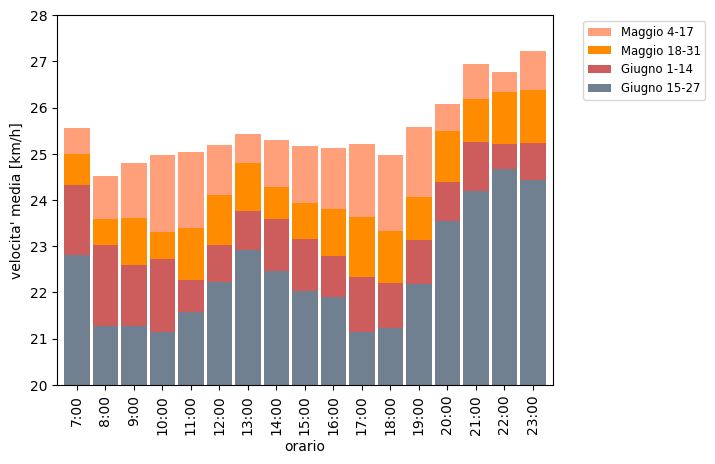

In [7]:
lst = [
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Car'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Car'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Car'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Car')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=myindex,
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

a = list_minus(lst[0], lst[1])
b = list_minus(lst[1], lst[2])
c = list_minus(lst[2], lst[3])
d = lst[3]

lst = [d, c, b, a]

array = np.array(lst).T

x = pd.DataFrame(array, index=myindex, columns=['Giugno 15-27', 'Giugno 1-14', 'Maggio 18-31', 'Maggio 4-17'])

x.plot.bar(stacked=True, width=0.9, align='center', color=['slategray', 'indianred', 'darkorange', 'lightsalmon'])

plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(reversed(plt.legend().legendHandles), reversed(['Giugno 15-27', 'Giugno 1-14', 'Maggio 18-31', 'Maggio 4-17']), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.yticks(range(0, 31, 1))
plt.ylim((20, 28))

plt.show()

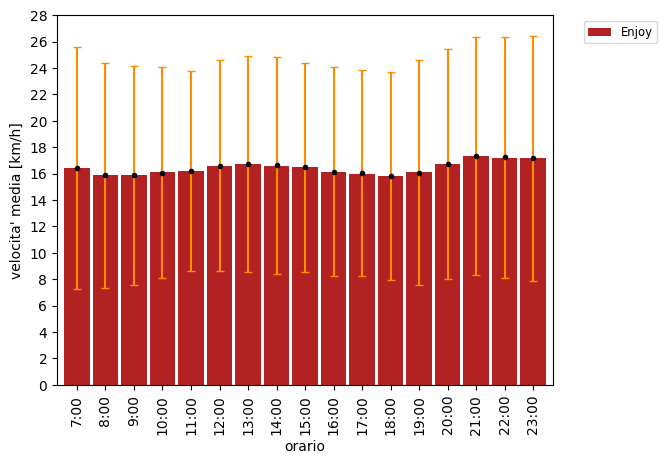

In [8]:
vmedia_week(tragitti, 'Enjoy').plot.bar(width=0.9, align='center', color=colori[1])
plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

x = plterrindex
y = vmedia_week_list(tragitti, 'Enjoy')[0]
dy = np.round(vstd_giorno(tragitti, 'Enjoy'), 1).tolist()
plt.errorbar(x, y, yerr=dy, lw=1.5, fmt='.k', color='black', ecolor='darkorange', capsize=3)

plt.yticks(range(0, 29, 2))
plt.show()

In [9]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Enjoy']
velocita_media.describe()

count    49560.000000
mean        16.477040
std          4.264505
min          3.532163
25%         13.455500
50%         16.287250
75%         19.285104
max         46.417286
dtype: float64

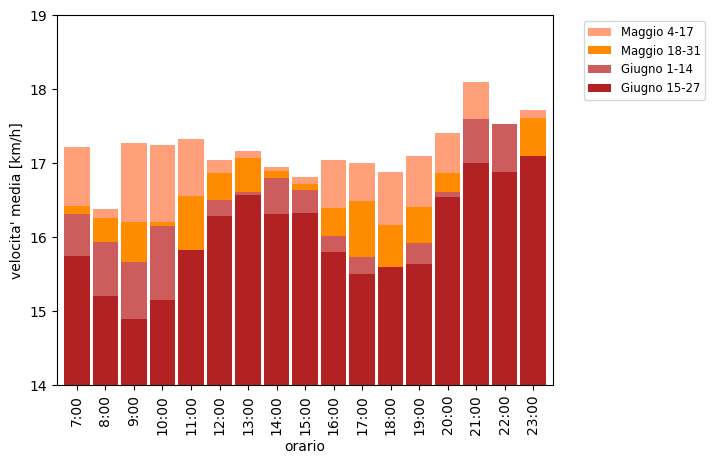

In [10]:
lst = [
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(4, 17)], 'Enjoy'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 5) & tragitti['Day'].between(18, 31)], 'Enjoy'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(1, 14)], 'Enjoy'),
    vmedia_giorno(tragitti[(tragitti['Month'] == 6) & tragitti['Day'].between(15, 27)], 'Enjoy')]

array = np.array(lst).T

confronto_vmedie_week_by_week = pd.DataFrame(
    array,
    index=myindex,
    columns=['Maggio 4-17', 'Maggio 18-31', 'Giugno 1-14', 'Giugno 15-27']).round(decimals=1)

a = list_minus(lst[0], lst[1])
b = list_minus(lst[1], lst[2])
c = list_minus(lst[2], lst[3])
d = lst[3]

lst = [d, c, b, a]

array = np.array(lst).T

x = pd.DataFrame(array, index=myindex, columns=['Giugno 15-27', 'Giugno 1-14', 'Maggio 18-31', 'Maggio 4-17'])

x.plot.bar(stacked=True, width=0.9, align='center', color=['firebrick', 'indianred', 'darkorange', 'lightsalmon'])

plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(reversed(plt.legend().legendHandles), reversed(['Giugno 15-27', 'Giugno 1-14', 'Maggio 18-31', 'Maggio 4-17']), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.yticks(range(0, 31, 1))
plt.ylim((14, 19))

plt.show()

In [11]:
x, y = vmedia_week_list(tragitti[we], 'Enjoy')[0], vmedia_week_list(tragitti[w], 'Enjoy')[0]
for i in range(0, len(x)):
    z = x[i] - y[i]
    print (z / x[i]) * 100

2.44006688193
8.76811442991
3.8353725974
1.06933646105
-0.0199506622976
-1.59234050625
-0.870852204514
-3.51513402117
-0.864249720288
-0.924177470789
0.806388761167
-0.646649783393
-2.91354143271
-1.35261068749
-1.89965952264
-2.46357144819
-3.31620804621


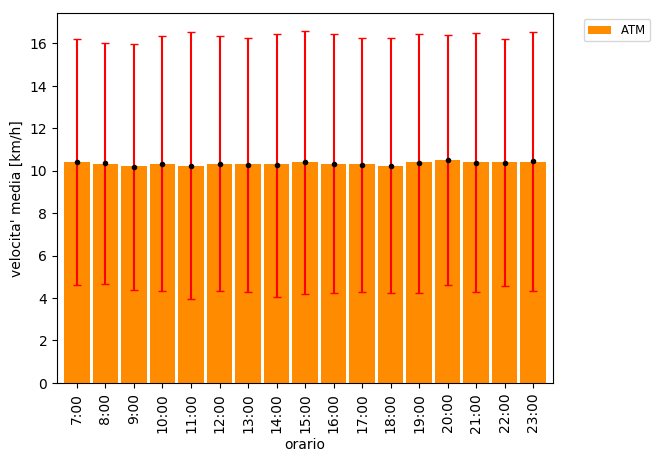

In [12]:
vmedia_week(tragitti, 'Public').plot.bar(width=0.9, align='center', color=colori[2])
plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

x = plterrindex
y = vmedia_week_list(tragitti, 'Public')[0]
dy = np.round(vstd_giorno(tragitti, 'Public'), 1).tolist()
plt.errorbar(x, y, yerr=dy, lw=1.5, fmt='.k', color='black', ecolor='red', capsize=3)

plt.yticks(range(0, 17, 2))
plt.show()

In [13]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Public']
velocita_media.describe()

count    49560.000000
mean        10.278539
std          2.985263
min          3.714837
25%          8.149819
50%          9.754315
75%         11.821679
max         41.096000
dtype: float64

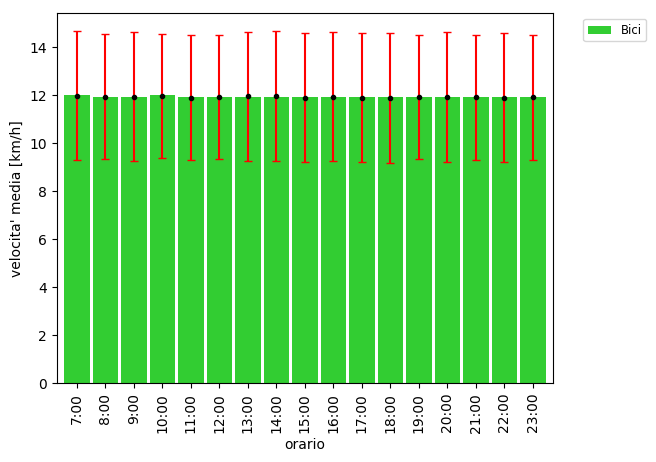

In [14]:
distance_param = 'FDistance'

vmedia_week(tragitti, 'Bike').plot.bar(width=0.9, align='center', color=colori[3])
plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

x = plterrindex
y = vmedia_week_list(tragitti, 'Bike')[0]
dy = np.round(vstd_giorno(tragitti, 'Bike'), 1).tolist()
plt.errorbar(x, y, yerr=dy, lw=1.5, fmt='.k', color='black', ecolor='red', capsize=3)

plt.yticks(range(0, 15, 2))
plt.show()

In [15]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Bike']
velocita_media.describe()

count    49560.000000
mean        11.916091
std          1.328412
min          6.510923
25%         11.050980
50%         11.992858
75%         12.845615
max         16.921800
dtype: float64

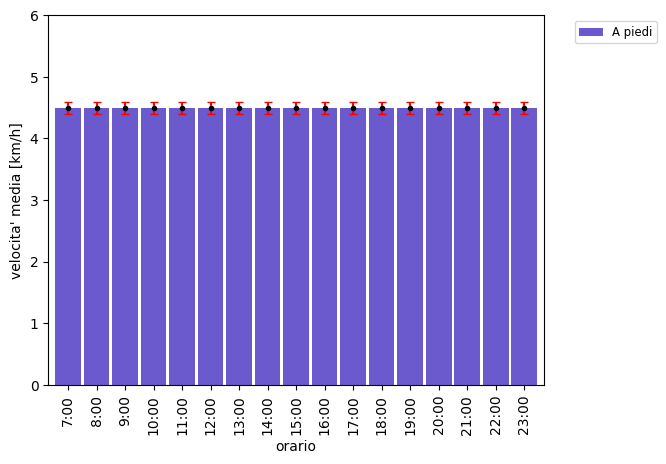

In [16]:
vmedia_week(tragitti, 'Foot').plot.bar(width=0.9, align='center', color=colori[4])
plt.xlabel('orario')
plt.ylabel('velocita\' media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

x = plterrindex
y = vmedia_week_list(tragitti, 'Foot')[0]
dy = np.round(vstd_giorno(tragitti, 'Foot'), 1).tolist()
plt.errorbar(x, y, yerr=dy, lw=1.5, fmt='.k', color='black', ecolor='red', capsize=3)

plt.yticks(range(0, 7, 1))
plt.show()

In [17]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Foot']
velocita_media.describe()

count    49560.000000
mean         4.490490
std          0.026456
min          4.327650
25%          4.471354
50%          4.490108
75%          4.509067
max          4.575600
dtype: float64

In [18]:
distance_param = 'CDistance'
lst = [
    vmedia_week_list(tragitti, 'Car')[0],
    vmedia_week_list(tragitti, 'Enjoy')[0]]

distance_param = 'FDistance'
lst.append(vmedia_week_list(tragitti, 'Bike')[0])

distance_param = 'CDistance'
lst.append(vmedia_week_list(tragitti, 'Public')[0])

distance_param = 'FDistance'
lst.append(vmedia_week_list(tragitti, 'Foot')[0])

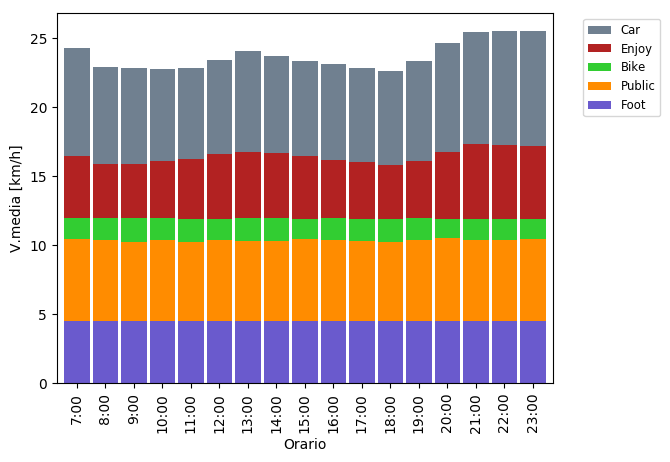

In [19]:
distance_param = 'CDistance'
lst = [
    vmedia_week_list(tragitti, 'Car')[0],
    vmedia_week_list(tragitti, 'Enjoy')[0]]

distance_param = 'FDistance'
lst.append(vmedia_week_list(tragitti, 'Bike')[0])

distance_param = 'CDistance'
lst.append(vmedia_week_list(tragitti, 'Public')[0])

distance_param = 'FDistance'
lst.append(vmedia_week_list(tragitti, 'Foot')[0])

def list_minus(l1, l2):
    r = []
    for i in range(0, len(l1)):
        r.append(l1[i] - l2[i])
    return r

a = list_minus(lst[0], lst[1])
b = list_minus(lst[1], lst[2])
c = list_minus(lst[2], lst[3])
d = list_minus(lst[3], lst[4])
e = lst[4]

lst = [e, d, c, b, a]

array = np.array(lst).T

x = pd.DataFrame(array, index=myindex, columns=['Foot', 'Public', 'Bike', 'Enjoy', 'Car'])
colori = ['slateblue', 'darkorange', 'limegreen', 'firebrick', 'slategray']
x.plot.bar(color=colori, stacked=True, width=0.9, align='center')

plt.xlabel('Orario')
plt.ylabel('V.media [km/h]')
plt.legend(reversed(plt.legend().legendHandles), reversed(['Foot', 'Public', 'Bike', 'Enjoy', 'Car']), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.show()